In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import statistics as stat
import math
import pandas as pd

### The data

In [2]:
N=500
xgauss1=[rd.gauss(mu=0,sigma=1) for i in range(N)]
xgauss2=[rd.gauss(0,1) for i in range(N)]

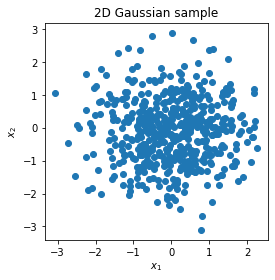

In [3]:
plt.figure(figsize=(4,4))
plt.scatter(xgauss1,xgauss2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('2D Gaussian sample')
plt.show()

### A labeled Data Set

In [4]:
group1=np.random.multivariate_normal([2.5,2.5],
                                     [[2,-0.8],[-0.8,2]],100)
group2=np.random.multivariate_normal([0,0],
                                     [[1,0],[0,1]],200)

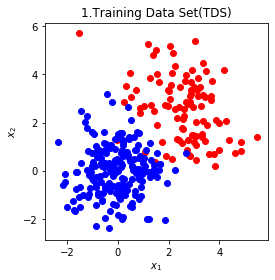

In [5]:
plt.figure(figsize=(4,4))
plt.scatter(group1[:,0],group1[:,1],c='red')
plt.scatter(group2[:,0],group2[:,1],c='blue')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('1.Training Data Set(TDS)')
plt.show()

### New data inputs without label

In [6]:
x1_min = min(np.concatenate((group1[:,0],group2[:,0])))
x1_max = max(np.concatenate((group1[:,0],group2[:,0])))
x2_min = min(np.concatenate((group1[:,1],group2[:,1])))
x2_max = max(np.concatenate((group1[:,1],group2[:,1])))
Neval=15
h1=(x1_max-x1_min)/Neval
h2=(x2_max-x2_min)/Neval
x1Eval,x2Eval = np.meshgrid(np.arange(x1_min,x1_max,h1),np.arange(x2_min,x2_max,h2))

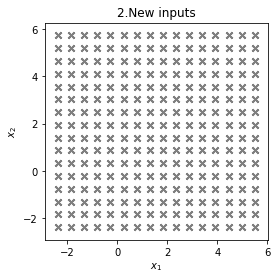

In [7]:
plt.figure(figsize=(4,4))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('2.New inputs')
for x1 in x1Eval:
    for x2 in x2Eval:
        plt.scatter(x1,x2,marker='x',c='gray')

## The naive Bayes model

In [8]:
data1 = pd.DataFrame({'x1':group1[:,0],'x2':group1[:,1],'label':[1 for i in range(group1.shape[0])]})
data2 = pd.DataFrame({'x1':group2[:,0],'x2':group2[:,1],'label':[0 for i in range(group2.shape[0])]})
#our final data set
data=pd.concat([data1,data2],ignore_index=True)


In [9]:
# the prior probability for each given class
def prior_prob(data=data):
    counts = data.label.value_counts()
    prob = counts/data.shape[0]
    return prob

# the Likelihood probability with each input for each class
def estm(data=data):
    params = {'mu':[], 'var':[]}
    for label in data.label.unique():
        subset = data[data['label']==label]
        mu = subset.iloc[:,:-1].mean(axis=0)
        covar = np.dot((subset.iloc[:,:-1]-mu).T,(subset.iloc[:,:-1]-mu))/data.shape[0]
        params['mu'].append(mu)
        params['var'].append(covar)
    return params

# the posterior probability of each observation 
def post_prob(x, mle_res, prior_res):
    n = 0
    res = []
    labels = data.label.unique()
    for label in labels:
        mu = mle_res['mu'][n].to_numpy()
        var = mle_res['var'][n]

        f_x = 1/((2*math.pi)**(x.shape[0]/2) * math.sqrt(np.linalg.det(var))) * math.exp(-1/2 * ((x-mu).T).dot(np.linalg.inv(var)).dot(x-mu))
        sigma_y = math.log(f_x) + math.log(prior_res[n])
        res.append(sigma_y)
        n = n+1
    index_pre = np.argmax(res)
    return labels[index_pre]

In [10]:
prior_prob = prior_prob(data)
mle_res = estm(data)

data['label_pred'] = np.nan
data

,x1,x2,label,label_pred
0,2.831790,2.851856,1,NaN
1,1.890148,0.602122,1,NaN
2,1.601111,3.686144,1,NaN
3,3.173192,3.116144,1,NaN
4,1.504837,5.029437,1,NaN
...,...,...,...,...
295,0.066582,-0.851000,0,NaN
296,0.200262,-0.917914,0,NaN
297,0.162943,-1.999148,0,NaN
298,0.549480,0.182067,0,NaN


In [11]:
for i in range(data.shape[0]):
    x = data.iloc[i,:2]
    data.loc[i,'label_pred'] = post_prob(x,mle_res,prior_prob)

In [12]:
data

,x1,x2,label,label_pred
0,2.831790,2.851856,1,1.0
1,1.890148,0.602122,1,0.0
2,1.601111,3.686144,1,1.0
3,3.173192,3.116144,1,1.0
4,1.504837,5.029437,1,1.0
...,...,...,...,...
295,0.066582,-0.851000,0,0.0
296,0.200262,-0.917914,0,0.0
297,0.162943,-1.999148,0,0.0
298,0.549480,0.182067,0,0.0


### Evaluation of the model

In [42]:
N = data.shape[0]

# number of errors
err = N-sum(data.loc[:,'label']==data.loc[:,'label_pred'])
# number of false positive
FP = sum([(data.loc[i,'label']==0) & (data.loc[i,'label_pred']==1) for i in range(data.shape[0])])
# number of false negative
FN = sum([(data.loc[i,'label']==1) & (data.loc[i,'label_pred']==0) for i in range(data.shape[0])])

print({'error':err,'FP':FP,'FN':FN})

{'error': 5, 'FP': 1, 'FN': 4}


In [50]:
# accuracy
acc = (N-err)/N
# precision
TP = sum([(data.loc[i,'label']==1) & (data.loc[i,'label_pred']==1) for i in range(data.shape[0])])
precision = TP/(TP+FP)
# recall
recall = TP/(TP+FN)
# F1-score
F1_score = 2/(1/precision + 1/recall)
print({'accuracy':acc,'precision':precision,'recall':recall,'F1-score':F1_score})

{'accuracy': 0.9833333333333333, 'precision': 0.9896907216494846, 'recall': 0.96, 'F1-score': 0.9746192893401017}


### Class Prediction for new inputs using the calibrated naive Bayes model

2.052083333333333